# ------- 1. Libraries and File Paths -------

In [2]:
import pandas as pd
import os
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rioxarray as rxr
from dask.diagnostics import ProgressBar

In [3]:
# Setting file paths
base_dir = "/global/scratch/users/yougsanghvi"

# Paths for stagg aggregated files for a specific year
stagg_folder_path = os.path.join(base_dir, "aggregated_results_gdnat_usa")
stagg_filename = "gdnat_usa_agg_1979.csv"
stagg_data_path = os.path.join(stagg_folder_path, stagg_filename)

# Paths for stagg aggregated files for all years
stagg_filename_allyrs = "gdnat_usa_agg_all_years.csv"
stagg_data_path_allyrs = os.path.join(stagg_folder_path, stagg_filename_allyrs)

# Paths for raw Gdnat data
raw_filename = "gdnat_1979.tif"
raw_filepath = os.path.join(base_dir, raw_filename)

# Define paths for world county shapefile
world_county_dir = os.path.join(base_dir, "gadm36_levels_shp")
world_county_filename = "gadm36_2.shp"
world_county_path = os.path.join(world_county_dir, world_county_filename)

# Paths for raw gdnat data
data_dir_cullen = os.path.join(
    "/global",
    "scratch",
    "users",
    "cmolitor",
)

data_dir_gdnat = os.path.join(data_dir_cullen, "global_suicide")
gdnat_1_path = os.path.join(
    data_dir_gdnat,
    "climate_data",
    "gdnat_ACCESS-CM2_tas_1979-1999_v2025-02-11.zarr",
)

gdnat_2_path = os.path.join(
    data_dir_gdnat,
    "climate_data",
    "gdnat_ACCESS-CM2_tas_2000-2020_v2025-02-11.zarr",
)


# ------- 2. Loading in Files -------

In [4]:
# narrowing the world shapefile by country (currently just for USA)

world_counties = gpd.read_file(world_county_path)
usa_counties = world_counties[world_counties["GID_0"] == "USA"]

# Save to a new shapefile
usa_county_path = os.path.join(base_dir, "gadm36_usa_counties.shp")
usa_counties.to_file(usa_county_path)

print(f"Saved USA usa_counties to: {usa_county_path}")

Saved USA usa_counties to: /global/scratch/users/yougsanghvi/gadm36_usa_counties.shp


In [4]:
# load file for all years combined
stagg_usa_data_allyrs = pd.read_csv(stagg_data_path_allyrs)

# Convert 'order_1' from monthly sum to approximate daily average
stagg_usa_data_allyrs["order_1_daily_avg"] = stagg_usa_data_allyrs["order_1"] / 30

# Summary statistics of the daily average
stagg_usa_data_allyrs

,year,month,poly_id,order_1,order_2,order_3,order_4,order_1_daily_avg
0,1979,1.0,USA.1.1_1,158.814365,1654.741608,19808.009713,2.746721e+05,5.293812
1,1979,2.0,USA.1.1_1,216.764644,2515.971735,34657.603576,5.238516e+05,7.225488
2,1979,3.0,USA.1.1_1,451.500318,7085.977789,117564.953892,2.028333e+06,15.050011
3,1979,4.0,USA.1.1_1,562.943206,10717.534714,206797.582781,4.039714e+06,18.764774
4,1979,5.0,USA.1.1_1,661.302793,14233.954373,308791.037713,6.745573e+06,22.043426
...,...,...,...,...,...,...,...,...
1571047,2020,8.0,USA.51.23_1,657.701321,14588.317797,333599.741465,7.811245e+06,21.923377
1571048,2020,9.0,USA.51.23_1,375.224280,5776.395082,95072.078203,1.659739e+06,12.507476
1571049,2020,10.0,USA.51.23_1,95.028564,2496.181591,17704.214776,4.242605e+05,3.167619
1571050,2020,11.0,USA.51.23_1,60.085026,996.307838,7669.912958,9.238767e+04,2.002834


In [ ]:
# load file for specific year speficied in path before
stagg_usa_data = pd.read_csv(stagg_data_path)

# Convert 'order_1' from monthly sum to approximate daily average
stagg_usa_data["order_1_daily_avg"] = stagg_usa_data["order_1"] / 30

# Summary statistics of the daily average
print(stagg_usa_data["order_1_daily_avg"].describe())

count    37404.000000
mean        12.230832
std         10.785589
min        -24.033382
25%          5.032352
50%         13.799075
75%         21.100664
max         35.181143
Name: order_1_daily_avg, dtype: float64


In [ ]:
# load raw file for specific year

rds = rxr.open_rasterio(raw_filepath, masked=True)

In [5]:
# Load raw file for all years
gdnat_1 = xr.open_dataset(gdnat_1_path, chunks={"time": 365})
gdnat_2 = xr.open_dataset(gdnat_1_path, chunks={"time": 365})

# ------- 3. Verifying file correctness -------

In [6]:
# NA checks for aggregated output

# The two county IDs with NAs:
na_counties = ["USA.10.44_1", "USA.24.39_1"]

# Filter for those counties by GID_2
filtered = usa_counties[usa_counties['GID_2'].isin(na_counties)]

# Display the relevant columns (GID_2 and NAME_2)
print(filtered[['GID_2', 'NAME_2']])

             GID_2             NAME_2
41287  USA.10.44_1             Monroe
42281  USA.24.39_1  Lake of the Woods


# ------- 4. Plotting for one specific year -------

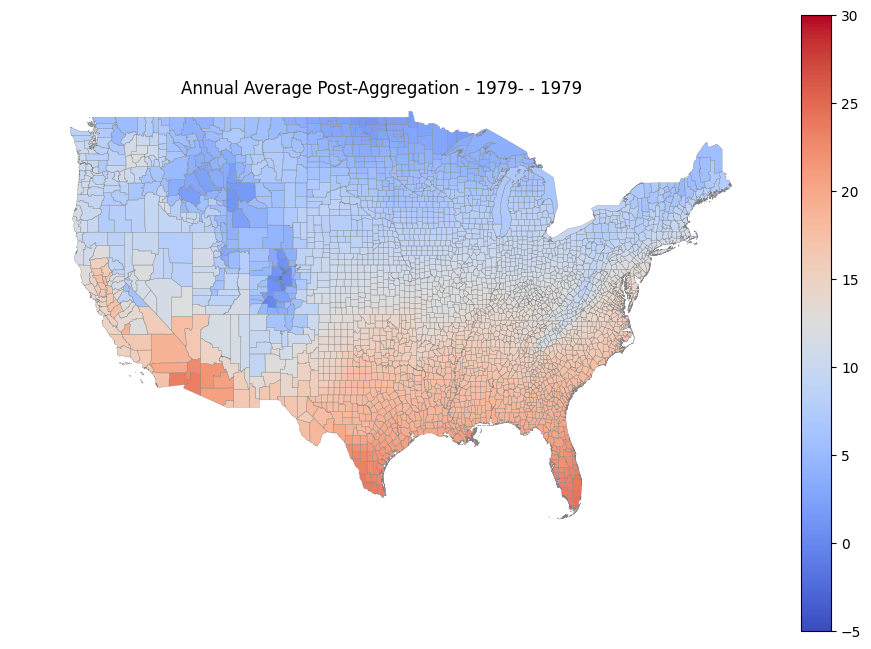

In [ ]:
# Calculate annual average temperature per polygon (poly_id)
annual_avg = (
    stagg_usa_data.groupby(["poly_id", "year"])["order_1_daily_avg"]
    .mean()
    .reset_index()
)

# If you want to focus on a specific year (e.g., 1979), filter:
year_focus = 1979
annual_avg_year = annual_avg[annual_avg["year"] == year_focus]

# Merge your data with the geodataframe
usa_counties = usa_counties.merge(
    annual_avg_year, how="left", left_on="GID_2", right_on="poly_id"
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
usa_counties.boundary.plot(ax=ax, color="gray", linewidth=0.2)
usa_counties.plot(
    column="order_1_daily_avg",
    ax=ax,
    cmap="coolwarm",
    legend=True,
    vmin=-5,  # min temperature for color scale
    vmax=30,  # max temperature for color scale
)

# Set plot extents for mainland USA (approx.)
ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)

ax.set_title(f"Annual Average Post-Aggregation - 1979- - {year_focus}")
ax.axis("off")
plt.show()


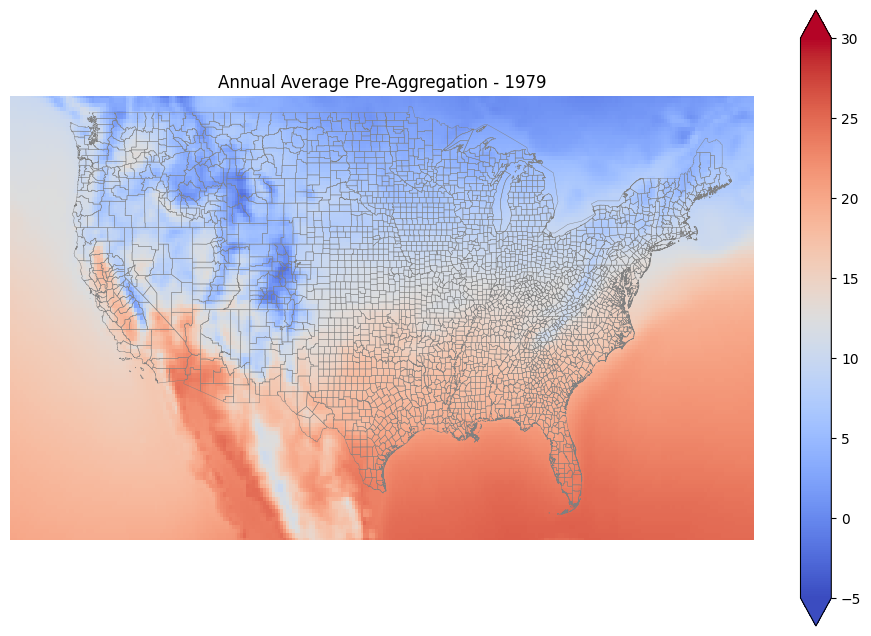

In [ ]:
# Shift longitudes from 0–360 to -180–180
rds = rds.assign_coords({"x": ((rds.x + 180) % 360) - 180}).sortby("x")

# Calculate the mean across bands → axis=0 for band dimension
annual_avg = rds.mean(dim="band", skipna=True)

# Convert from Kelvin to Celsius
annual_avg_celsius = annual_avg - 273.15

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
annual_avg_celsius.plot(ax=ax, cmap="coolwarm", vmin=-5, vmax=30)
usa_counties.to_crs(annual_avg_celsius.rio.crs).boundary.plot(
    ax=ax, color="grey", linewidth=0.3
)

ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)
ax.set_title("Annual Average Pre-Aggregation - 1979")
ax.axis("off")
plt.show()

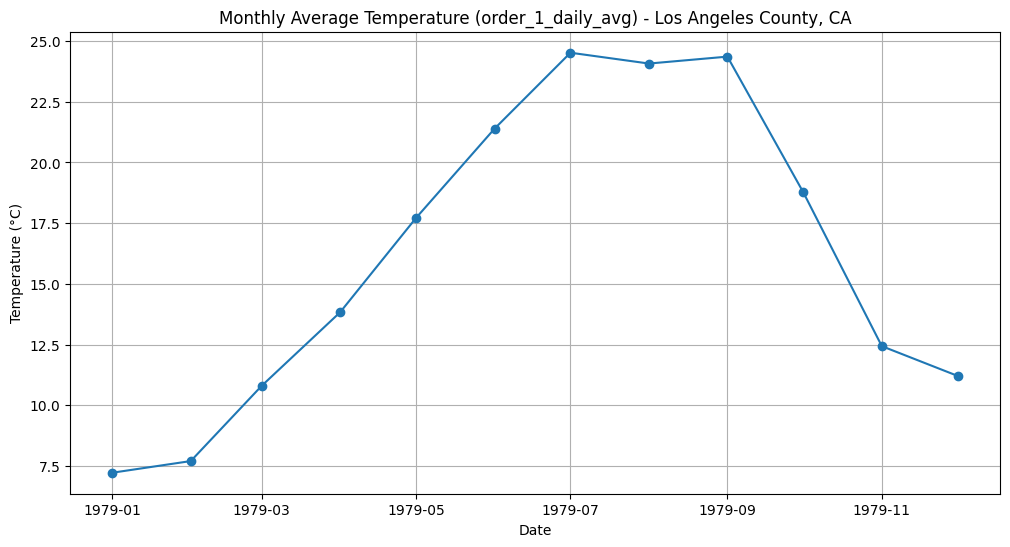

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Find Alameda county polygon ID directly by name
alameda_gid2 = usa_counties.loc[
    usa_counties["NAME_2"] == "Los Angeles", "GID_2"
].values[0]

# Filter stagg data for Alameda county
alameda_data = stagg_usa_data[stagg_usa_data["poly_id"] == alameda_gid2]

# Sort by year and month
alameda_data = alameda_data.sort_values(["year", "month"])

# Create a datetime column for plotting
alameda_data["date"] = pd.to_datetime(
    dict(year=alameda_data["year"], month=alameda_data["month"], day=1)
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(
    alameda_data["date"], alameda_data["order_1_daily_avg"], marker="o", linestyle="-"
)

ax.set_title("Monthly Average Temperature (order_1_daily_avg) - Los Angeles County, CA")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.grid(True)

plt.show()


In [ ]:
stagg_usa_data
usa_counties

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,geometry,poly_id_x,year_x,order_1_daily_avg_x,poly_id_y,year_y,order_1_daily_avg_y,poly_id,year,order_1_daily_avg
0,USA,United States,USA.1_1,Alabama,None,USA.1.1_1,Autauga,None,None,County,...,"POLYGON ((-86.81896 32.34027, -86.81084 32.347...",USA.1.1_1,1979.0,17.655739,USA.1.1_1,1979.0,17.655739,USA.1.1_1,1979.0,17.655739
1,USA,United States,USA.1_1,Alabama,None,USA.1.2_1,Baldwin,None,None,County,...,"MULTIPOLYGON (((-87.51056 30.33972, -87.51083 ...",USA.1.2_1,1979.0,19.261450,USA.1.2_1,1979.0,19.261450,USA.1.2_1,1979.0,19.261450
2,USA,United States,USA.1_1,Alabama,None,USA.1.3_1,Barbour,None,None,County,...,"POLYGON ((-85.13026 31.76386, -85.13504 31.768...",USA.1.3_1,1979.0,17.936807,USA.1.3_1,1979.0,17.936807,USA.1.3_1,1979.0,17.936807
3,USA,United States,USA.1_1,Alabama,None,USA.1.4_1,Bibb,None,None,County,...,"POLYGON ((-87.42078 32.87446, -87.42028 32.971...",USA.1.4_1,1979.0,17.345154,USA.1.4_1,1979.0,17.345154,USA.1.4_1,1979.0,17.345154
4,USA,United States,USA.1_1,Alabama,None,USA.1.5_1,Blount,None,None,County,...,"POLYGON ((-86.95322 33.81542, -86.95449 33.845...",USA.1.5_1,1979.0,16.236021,USA.1.5_1,1979.0,16.236021,USA.1.5_1,1979.0,16.236021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3143,USA,United States,USA.51_1,Wyoming,None,USA.51.19_1,Sweetwater,None,None,County,...,"POLYGON ((-110.00014 40.99923, -110.0485 40.99...",USA.51.19_1,1979.0,5.510439,USA.51.19_1,1979.0,5.510439,USA.51.19_1,1979.0,5.510439
3144,USA,United States,USA.51_1,Wyoming,None,USA.51.20_1,Teton,None,None,County,...,"POLYGON ((-111.04494 43.50049, -111.04498 43.5...",USA.51.20_1,1979.0,1.195070,USA.51.20_1,1979.0,1.195070,USA.51.20_1,1979.0,1.195070
3145,USA,United States,USA.51_1,Wyoming,None,USA.51.21_1,Uinta,None,None,County,...,"POLYGON ((-110.0485 40.99883, -110.05729 40.99...",USA.51.21_1,1979.0,4.888746,USA.51.21_1,1979.0,4.888746,USA.51.21_1,1979.0,4.888746
3146,USA,United States,USA.51_1,Wyoming,None,USA.51.22_1,Washakie,None,None,County,...,"POLYGON ((-107.10772 43.49963, -107.14559 43.4...",USA.51.22_1,1979.0,6.166563,USA.51.22_1,1979.0,6.166563,USA.51.22_1,1979.0,6.166563


# ------- 5. Plotting average across all years -------

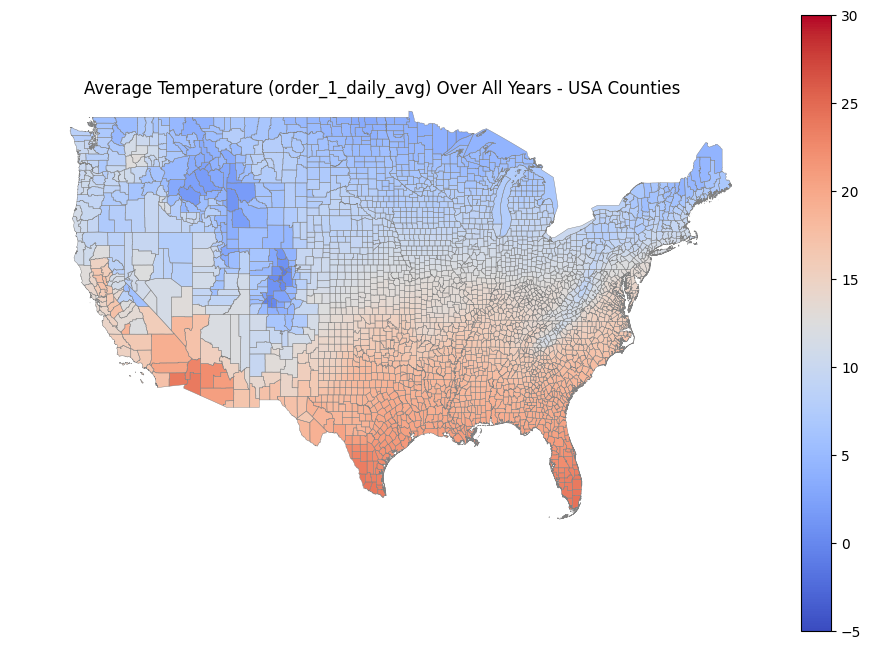

In [15]:
# Calculate average temperature per polygon (poly_id) over all years
annual_avg_all_years = (
    stagg_usa_data_allyrs.groupby("poly_id")["order_1_daily_avg"].mean().reset_index()
)

# Merge the averaged data with county GeoDataFrame
usa_counties_all_years = usa_counties.merge(
    annual_avg_all_years, how="left", left_on="GID_2", right_on="poly_id"
)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Grey county boundaries
usa_counties_all_years.boundary.plot(ax=ax, color="grey", linewidth=0.3)

# Plot average temperature with fixed scale
usa_counties_all_years.plot(
    column="order_1_daily_avg", ax=ax, cmap="coolwarm", legend=True, vmin=-5, vmax=30
)

# Zoom to mainland USA
ax.set_xlim(-130, -65)
ax.set_ylim(23, 50)

ax.set_title("Average Temperature (order_1_daily_avg) Over All Years - USA Counties")
ax.axis("off")
plt.show()


-180.0 179.75
[########################################] | 100% Completed | 18.88 s


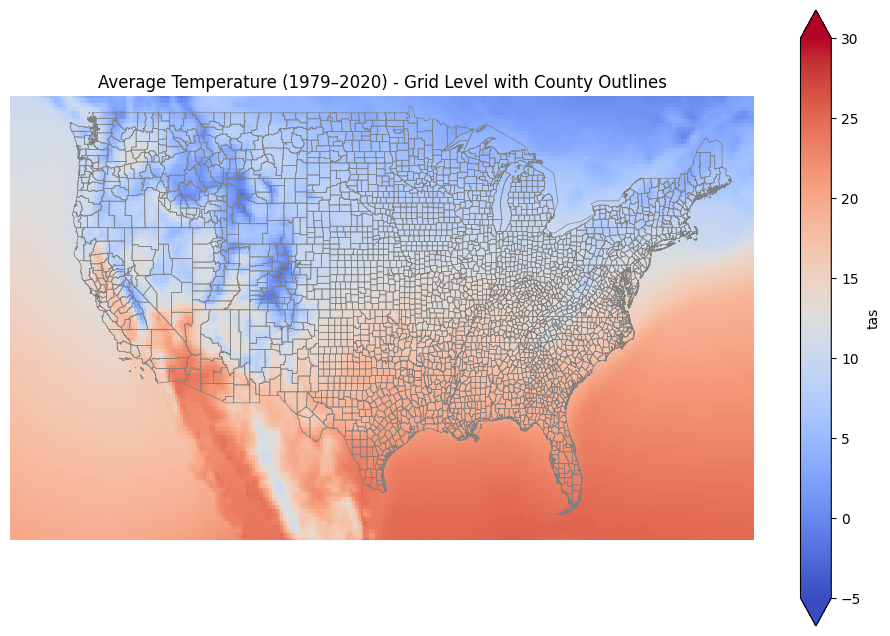

In [ ]:
# Plot raw data


# Concatenate along time dimension
gdnat_all = xr.concat([gdnat_1, gdnat_2], dim="time")

# Compute the mean over time dimension (lazy, waits until plot to compute)
annual_avg = gdnat_all["tas"].mean(dim="time", skipna=True)

# Convert to Celsius (assuming 'tas' is in Kelvin)
annual_avg_celsius = annual_avg - 273.15
annual_avg_celsius = annual_avg_celsius.rio.write_crs("EPSG:4326", inplace=True)

# Shift longitudes from 0–360 → -180–180, explicitly assigned
annual_avg_celsius = annual_avg_celsius.assign_coords(
    lon=(((annual_avg_celsius.lon + 180) % 360) - 180)
)

# Sort by longitude for proper plotting
annual_avg_celsius = annual_avg_celsius.sortby('lon')

# Confirm it worked:
# print(annual_avg_celsius.lon.values.min(), annual_avg_celsius.lon.values.max())

# Plot with progress bar for compute
with ProgressBar():
    fig, ax = plt.subplots(figsize=(12, 8))
    annual_avg_celsius.plot(ax=ax, cmap="coolwarm", vmin=-5, vmax=30)
    usa_counties.to_crs(annual_avg_celsius.rio.crs).boundary.plot(
        ax=ax, color="grey", linewidth=0.5
    )
    ax.set_xlim(-130, -65)
    ax.set_ylim(23, 50)
    ax.set_title("Average Temperature (1979–2020) - Grid Level with County Outlines")
    ax.axis("off")
    plt.show()
